### Linear Gaussian Model

In [2]:
import numpy as np 

#### Auxiliary functions

In [3]:
# Skeleton definition
NUI_SKELETON_POSITION_COUNT = 20

NONE = -1
HIP_CENTER = 0
SPINE = 1
SHOULDER_CENTER = 2
HEAD = 3
SHOULDER_LEFT = 4
ELBOW_LEFT = 5
WRIST_LEFT = 6
HAND_LEFT = 7
SHOULDER_RIGHT = 8
ELBOW_RIGHT = 9
WRIST_RIGHT = 10
HAND_RIGHT = 11
HIP_LEFT = 12
KNEE_LEFT = 13
ANKLE_LEFT = 14
FOOT_LEFT = 15
HIP_RIGHT = 16
KNEE_RIGHT = 17
ANKLE_RIGHT = 18
FOOT_RIGHT = 19

nui_skeleton_names = ( \
    'HIP_CENTER', 'SPINE', 'SHOULDER_CENTER', 'HEAD', \
    'SHOULDER_LEFT', 'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', \
    'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT', \
    'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT', 'FOOT_LEFT', \
    'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT' )

nui_skeleton_conn = ( \
    NONE, \
    HIP_CENTER, \
    SPINE, \
    SHOULDER_CENTER, \
    # Left arm 
    SHOULDER_CENTER, \
    SHOULDER_LEFT,  \
    ELBOW_LEFT,  \
    WRIST_LEFT,  \
    # Right arm 
    SHOULDER_CENTER,  \
    SHOULDER_RIGHT,  \
    ELBOW_RIGHT,  \
    WRIST_RIGHT,  \
    # Left leg 
    HIP_CENTER,  \
    HIP_LEFT,  \
    KNEE_LEFT,  \
    ANKLE_LEFT,  \
    # Right leg 
    HIP_CENTER,  \
    HIP_RIGHT,  \
    KNEE_RIGHT,  \
    ANKLE_RIGHT,  \
)


In [4]:
def load_dataset(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/data.mat')
    else:
        ex = scipy.io.loadmat(file)
        
    return ex['data'],ex['labels'],ex['individuals']

In [5]:
def log_normpdf(x, mu, sigma):
    """
      Computes the natural logarithm of the normal probability density function
      
    """
    #log_prob
    return -np.log(sigma*np.sqrt(2*np.pi))-np.power((x-mu),2) / (2*np.power(sigma,2))
     


In [6]:
def normalize_logprobs(log_probs):
    """
       Returns the log prob normalizes so that when exponenciated
       it adds up to 1 (Useful to normalizes logprobs)
    """
    mm = np.max(log_probs)
    return log_probs - mm - np.log(np.sum(np.exp(log_probs - mm)))


#### Functions to implement

In [7]:
def fit_gaussian(X, W=None):
    """
      Compute the mean and variance of X, 
      You can ignore W for the moment
    """
    mean = np.mean(X)
    sigma = np.std(X,axis = 0, ddof = 1)
    return (mean, sigma)


In [8]:
def my_cov(x,y,w):
    """
      Useful function for fit_linear_gaussian
    """
    return np.mean(x*y) - np.mean(x)*np.mean(y)
#     return np.sum(w*x*y)/np.sum(w)-np.sum(w*x)*np.sum(w*y)/np.sum(w)/np.sum(w)


In [9]:
def fit_linear_gaussian(Y,X,W = None):
    """
    Input:
      Y: vector of size D with the observations for the variable
      X: matrix DxV with the observations for the parent variables
                 of X. V is the number of parent variables
      W: vector of size D with the weights of the instances (ignore for the moment)
      
    Outout:
       The betas and sigma
    """
    if W is None:
        W = np.ones(Y.shape[0])
    (D,V) = np.array(X).shape
    # A construction
    A = np.zeros((V+1,V+1))
    A[0,0] = 1
    
    for i in range(1,(V+1)):
        A[0,i] = np.mean(X[:,i-1],dtype=np.float64)
    A[1:V+1,0] = np.transpose(A[0,1:V+1])
    
    for i in range(1,V+1):
        for j in range(1,V+1):
            A[i,j] = np.mean(np.multiply(X[:,i-1],X[:,j-1]),dtype=np.float64)
    
    # B construction 
    B = np.zeros( (V+1, 1) )
    B[0] = np.mean(Y,dtype=np.float64)
    for k in range(1,V+1):
          #Eval
#         B[k] = np.mean(np.multiply(Y[:,0], X[:,k-1]),dtype=np.float64)
        B[k] = np.mean(np.multiply(Y, X[:,k-1]),dtype=np.float64)

    # Compute betas
    betas = np.linalg.solve(A, B)

    # Compute sigma
    b = np.delete(betas, 0)
    cov_y = my_cov(Y,Y,W)
    sigma = 0
    for i in range(0,V):
        for j in range(0,V):
            cov = my_cov(X[:,i], X[:,j], W)
            sigma = sigma + b[i] * b[j] * cov
    sigma = np.sqrt(cov_y - sigma ) + 0.01

    return (betas,sigma)

In [10]:
def learn_model(dataset, labels, G=None):
    """
    Input:
     dataset: The data as it is loaded from load_data
     labels:  The labels as loaded from load_data
     Graph:   (optional) If None, this def should compute the naive 
           bayes model. If it contains a skel description (pe 
           nui_skeleton_conn, as obtained from skel_model) then it should
           compute the model using the Linear Gausian Model

    Output: the model
     a (tentative) structure for the output model is:
       model.connectivity: the input Graph variable should be stored here 
                           for later use.
       model.class_priors: containing a vector with the prior estimations
                           for each class
       model.jointparts[i] contains the estimated parameters for the i-th joint

          For joints that only depend on the class model.jointparts(i) has:
            model.jointparts(i).means: a matrix of 3 x #classes with the
                   estimated means for each of the x,y,z variables of the 
                   i-th joint and for each class.
            model.jointparts(i).sigma: a matrix of 3 x #classes with the
                   estimated stadar deviations for each of the x,y,z 
                   variables of the i-th joint and for each class.

          For joints that follow a gausian linear model model.jointparts(i) has:
            model.jointparts(i).betas: a matrix of 12 x #classes with the
                   estimated betas for each x,y,z variables (12 in total) 
                   of the i-th joint and for each class label.
            model.jointparts(i).sigma: as above

    """
    # dataset attribute sizes 
    total_joints = dataset.shape[0]
    total_vars = dataset.shape[1] # (x,y,z)
    total_instances = dataset.shape[2]
    total_classes = 4
    classes = np.unique(labels)

    model = lambda: None
    model.connectivity = None
    model.jointparts = [None]*total_joints
    model.class_priors = np.zeros(total_classes)
    # calculating priors
    class_bin = np.array([1,2,3,4,8])
    class_hist = np.histogram(labels,class_bin)[0]

    for i in range(0, total_classes):
        if class_hist[i] != 0:
            model.class_priors[i] = class_hist[i] / labels.shape[0]
    # Init joint parts        
    for i in range(0, total_joints):
        model.jointparts[i] = lambda: None
        model.jointparts[i].means = np.zeros((total_vars,total_classes))
        model.jointparts[i].betas = np.zeros((total_classes*total_vars,total_classes))
        model.jointparts[i].sigma = np.zeros((total_vars,total_classes))

    # NAIVE BAYES
    if G is None:
        for class_idx in range(0,total_classes):
            for i in range(0, total_joints):
                for j in range(0, total_vars):
                    ( model.jointparts[i].means[j,class_idx], model.jointparts[i].sigma[j,class_idx] ) = fit_gaussian(dataset[i,j,np.transpose(np.where(labels==classes[class_idx])[0])]) #np.transpose(np.where(labels==classes(class_idx)))
#                     model.jointparts[i].sigma[j,class_idx] = np.sqrt( model.jointparts[i].sigma[j,class_idx] )
    # LINEAR GAUSSIAN MODEL
    else:
        model.connectivity = G
        
        for class_idx in range(0,total_classes):
            for i in range(0, total_joints):
                for j in range(0, total_vars):
                    if i == 0:
                        ( model.jointparts[i].means[j,class_idx], model.jointparts[i].sigma[j,class_idx] ) = fit_gaussian(dataset[i,j,np.transpose(np.where(labels==classes[class_idx])[0])]) #np.transpose(np.where(labels==classes(class_idx)))
                    else:
                        parent_joint = G[i]
                        X = np.squeeze( dataset[parent_joint,:, np.transpose(np.where(labels==classes[class_idx])[0])] )
                        Y = np.squeeze( dataset[i,j,np.transpose(np.where(labels==classes[class_idx])[0])] ) #np.transpose(np.where(labels==classes(class_idx)))
                        (betas, sigma) = fit_linear_gaussian(Y,X)
                        model.jointparts[i].betas[j*total_classes:j*total_classes+total_vars+1,class_idx] = betas.ravel()
                        model.jointparts[i].sigma[j,class_idx] = sigma
        
                        
    return model

In [11]:
def classify_instances(instances, model):
    """    
    Input
       instance: a 20x3x#instances matrix defining body positions of
                 instances
       model: as the output of learn_model

    Output
       probs: a matrix of #instances x #classes with the probability of each
              instance of belonging to each of the classes

    Important: to avoid underflow numerical issues this computations should
               be performed in log space
    """

    total_instances = instances.shape[2]
    total_classes = 4

    probs = np.zeros( (total_instances, total_classes) )
    
    for i in range(0,total_instances):
        probs[i,:] = compute_logprobs(instances[:,:,i], model)
    # Exponentiate to convert the log range into [0,1]
    return np.exp(probs)

In [12]:
def compute_logprobs(example, model):
    """

       Input
           instance: a 20x3 matrix defining body positions of one instance
           model: as given by learn_model

       Output
           l: a vector of len #classes containing the loglikelihhod of the 
              instance

    """
    total_joints = example.shape[0]
    total_vars = example.shape[1] # (x,y,z)
    total_classes = 4
    
    l = np.zeros((total_classes))
    
    for class_idx in range(0,total_classes):
            for i in range(0, total_joints):
                for j in range(0, total_vars):
                    mean = 0
                    if i == 0 or model.connectivity is None:
                        mean =  model.jointparts[i].means[j,class_idx]
                    else:
                        parent = model.connectivity[i]
                        for k in range(0,total_vars+1):
                            acc = model.jointparts[i].betas[(j)*(total_classes)+k,class_idx]
                            if k != 0:
                                acc = acc * example[parent,k-1]
                            mean = mean + acc
                    sigma = model.jointparts[i].sigma[j][class_idx]
                    log_prob = log_normpdf(example[i,j], mean, sigma)
                    l[class_idx] = l[class_idx] + log_prob 
                    l[class_idx] + np.log(model.class_priors[class_idx])
    return normalize_logprobs(l)

In [13]:
def load_fit_test(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/ejemplolineargaussian.mat')
    else:
        ex = scipy.io.loadmat(file)
    ex = ex['ejemplo']    
    return ex['inputY'],ex['inputX'],ex['outputBetas'], ex['outputSigma']

In [14]:
def load_validation(file=None):
    """
      Returns the data, the labels and the person id for each action
    """
    import scipy.io
    
    if file is None:
        ex = scipy.io.loadmat('data/validation_data.mat')
    else:
        ex = scipy.io.loadmat(file)
    return ex['data_small'], ex['labels_small'], ex['train_indexes'],ex['test_indexes']#,ex['outputBetas'], ex['outputSigma']

In [15]:
# MAIN LAUNCHER
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# # TESTING fit_linear_gaussian
# (Y, X, opBetas, opSigma) = load_fit_test()
# Y_squeeze = Y[0][0] #np.squeeze(Y)
# X_squeeze = X[0][0] #np.squeeze(X)

# # flat_Y = [val for sublist in Y for val in sublist]

# (betas, sigma) = fit_linear_gaussian(Y_squeeze, X_squeeze)
# # print("X: ", X_squeeze)
# print("Betas: ", betas)
# print("Sigma: ", sigma)

# LOAD DATASET
(data, labels, individuals) = load_dataset('data/data.mat')

# (data, labels, indices_train, indices_test) = load_validation()

#CROSS VALIDATION
for i in range(1,11):
    # Divide data into train and test 
    data_train, data_test, labels_train, labels_test = train_test_split(np.transpose(data), labels, test_size=0.4)
    scores_NB = []
    scores_LGM = []
    data_trian = np.transpose(data_train)
    data_test = np.transpose(data_test)

#     indices = np.random.permutation(labels.shape[0])
#     train_max_index = int(np.round(individuals.shape[0]*.6))
#     indices_train = indices[0:train_max_index]
#     indices_test = indices[train_max_index:individuals.shape[0]]

    # Training 
    model_NB = learn_model(data_trian, labels_train)
    model_LGM = learn_model(data_trian, labels_train, nui_skeleton_conn)

    # Classification
    prob_NB = classify_instances(data_test, model_NB)
    prob_LGM = classify_instances(data_test, model_LGM)

    lbls_NB = np.argmax(prob_NB, axis=1)+1
    lbls_NB[lbls_NB == 4] = 8
    acc_nb = np.mean(labels_test.ravel()==lbls_NB)
    
    lbls_LGM = np.argmax(prob_LGM, axis=1)+1
    lbls_LGM[lbls_LGM == 4] = 8
    acc_lgm = np.mean(labels_test.ravel()==lbls_LGM)
    scores_NB.append(acc_nb)
    scores_LGM.append(acc_lgm)
    
print("NB Accuracy: " , np.mean(scores_NB))
print("LGM Accuracy: ", np.mean(scores_LGM))

target_names = ['both arms lifted', 'right arms extended', 'crouch', 'arms extended to one side']
print("#Naive Bayes")
print(classification_report(labels_test.ravel(), lbls_NB, target_names=target_names))
print("#LGM")
print(classification_report(labels_test.ravel(), lbls_LGM, target_names=target_names))


   

NB Accuracy:  0.9572127139364304
LGM Accuracy:  0.9963325183374083
#Naive Bayes
                           precision    recall  f1-score   support

         both arms lifted       1.00      0.94      0.97       192
      right arms extended       1.00      1.00      1.00       200
                   crouch       0.95      0.94      0.94       216
arms extended to one side       0.89      0.96      0.92       210

              avg / total       0.96      0.96      0.96       818

#LGM
                           precision    recall  f1-score   support

         both arms lifted       1.00      0.99      0.99       192
      right arms extended       1.00      1.00      1.00       200
                   crouch       1.00      1.00      1.00       216
arms extended to one side       0.99      1.00      0.99       210

              avg / total       1.00      1.00      1.00       818



# 4  Fold
NB Accuracy:  0.9301003189438348
LGM Accuracy:  0.9583297117522314
# 5  Fold
NB Accuracy:  0.9346293505129637
LGM Accuracy:  0.9704095363602028
# 6  Fold
NB Accuracy:  0.9485146024953671
LGM Accuracy:  0.9937065176258261
# 7  Fold
NB Accuracy:  0.9495787355900885
LGM Accuracy:  0.9918027210884353
# 8  Fold
NB Accuracy:  0.949001378186295
LGM Accuracy:  0.9909379931309756
# 10  Fold
NB Accuracy:  0.950031644897034
LGM Accuracy:  0.9923043400878836
# 20  Fold
NB Accuracy:  0.9499981507196378
LGM Accuracy:  0.9933379844670167


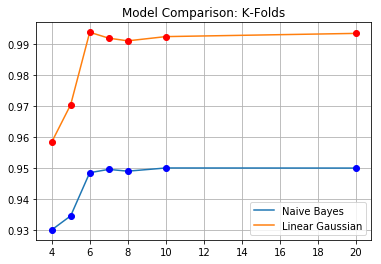

In [25]:
## KFOLD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# LOAD DATASET
(data, labels, individuals) = load_dataset('data/data.mat')
scores_fold_NB = []
scores_fold_LGM = []
for i in [4,5,6,7,8,10,20]:
    kf = StratifiedKFold(n_splits=i)
    scores_NB = []
    scores_LGM = []
    print("#",i," Fold")

    # Divide data into train and test 
    for train_index, test_index in kf.split(np.transpose(data),individuals):
        data_train = data[:,:,train_index]
        data_test = data[:,:,test_index]
        labels_train = labels[train_index]
        labels_test = labels[test_index]
        model_NB = learn_model(data_train, labels_train)
        model_LGM = learn_model(data_train, labels_train, nui_skeleton_conn)

        # Classification
        prob_NB = classify_instances(data_test, model_NB)
        prob_LGM = classify_instances(data_test, model_LGM)

        lbls_NB = np.argmax(prob_NB, axis=1)+1
        lbls_NB[lbls_NB == 4] = 8
        acc_nb = accuracy_score(labels_test.ravel(),lbls_NB)
        scores_NB.append(acc_nb)

        lbls_LGM = np.argmax(prob_LGM, axis=1)+1
        lbls_LGM[lbls_LGM == 4] = 8
        acc_lgm = accuracy_score(labels_test.ravel(),lbls_LGM)
        scores_LGM.append(acc_lgm)
    print("NB Accuracy: " , np.mean(scores_NB))
    print("LGM Accuracy: ", np.mean(scores_LGM))
    scores_fold_NB.append(np.mean(scores_NB))
    scores_fold_LGM.append(np.mean(scores_LGM))
fig = plt.figure()
ax = plt.subplot(111)
ax.plot([4,5,6,7,8,10,20], scores_fold_NB, label='Naive Bayes')
ax.plot([4,5,6,7,8,10,20], scores_fold_LGM, label='Linear Gaussian')
ax.plot([4,5,6,7,8,10,20], scores_fold_NB, 'bo')
ax.plot([4,5,6,7,8,10,20], scores_fold_LGM, 'ro')
plt.ylabel='Accuracy'
plt.xlabel='k-Folds'
plt.title('Model Comparison: K-Folds')
plt.grid(True)
ax.legend()
plt.show()

In [26]:
## LOO
from sklearn.model_selection import LeavePOut
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# LOAD DATASET
(data, labels, individuals) = load_dataset('data/data.mat')

scores_fold_NB = []
scores_fold_LGM = []

lpo = LeavePOut(p=1)    
scores_NB = []
scores_LGM = []
print("#",i," Fold")

# Divide data into train and test 
for train_index, test_index in lpo.split(np.transpose(data)):
    data_train = data[:,:,train_index]
    data_test = data[:,:,test_index]
    labels_train = labels[train_index]
    labels_test = labels[test_index]
    model_NB = learn_model(data_train, labels_train)
    model_LGM = learn_model(data_train, labels_train, nui_skeleton_conn)

    # Classification
    prob_NB = classify_instances(data_test, model_NB)
    prob_LGM = classify_instances(data_test, model_LGM)

    lbls_NB = np.argmax(prob_NB, axis=1)+1
    lbls_NB[lbls_NB == 4] = 8
    acc_nb = accuracy_score(labels_test.ravel(),lbls_NB)
    scores_NB.append(acc_nb)

    lbls_LGM = np.argmax(prob_LGM, axis=1)+1
    lbls_LGM[lbls_LGM == 4] = 8
    acc_lgm = accuracy_score(labels_test.ravel(),lbls_LGM)
    scores_LGM.append(acc_lgm)
    
print("NB Accuracy: " , np.mean(scores_NB))
print("LGM Accuracy: ", np.mean(scores_LGM))
# target_names = ['both arms lifted', 'right arms extended', 'crouch', 'arms extended to one side']
# print("#Naive Bayes")
# print(classification_report(labels_test.ravel(), lbls_NB, target_names=target_names))
# print("#LGM")
# print(classification_report(labels_test.ravel(), lbls_LGM, target_names=target_names))



# 20  Fold
NB Accuracy:  0.9511002444987775
LGM Accuracy:  0.9955990220048899
#Naive Bayes
                           precision    recall  f1-score   support

         both arms lifted       1.00      1.00      1.00         1

              avg / total       1.00      1.00      1.00         1

#LGM
                           precision    recall  f1-score   support

         both arms lifted       1.00      1.00      1.00         1

              avg / total       1.00      1.00      1.00         1



/home/kalex/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 4
  .format(len(labels), len(target_names))
